<a href="https://colab.research.google.com/github/kaveesha82/Telco-Customer-Churn/blob/main/CWDT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###importing librarises and data

In [14]:
# CODE BLOCK A: LIBRARIES, LOADING, AND INITIAL AUDIT
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score
import numpy as np

# Load the dataset
# IMPORTANT: Ensure 'WA_Fn-UseC_-Telco-Customer-Churn.csv' is uploaded to Colab's file session
df = pd.read_csv('/content/dataset.csv')

print("Initial Data Types:")
print(df.dtypes)

Initial Data Types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


### data cleaning


In [15]:
# CODE BLOCK B: UNIVERSAL CLEANING & TARGET ENCODING
# 1. Handle hidden TotalCharges missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') # Converts " " to NaN
df['TotalCharges'] = df['TotalCharges'].fillna(0) # Fills NaN with 0

# 2. Drop High Cardinality ID and Duplicates
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

df = df.drop_duplicates()
print(f"Dataset shape after cleaning: {df.shape}")

# 3. Encode Target 'Churn' (Yes -> 1, No -> 0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

Dataset shape after cleaning: (7021, 20)


###feature engeneering

In [16]:
# CODE BLOCK C: ENCODING AND FEATURE SETUP
# Apply One-Hot Encoding to the clean dataframe
df_encoded = pd.get_dummies(df, drop_first=True)

# Separate Features (X) and Target (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# Identify numerical columns for scaling later
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Initialize MinMaxScaler (required only for the Neural Network)
scaler = MinMaxScaler()

# Create Scaled versions of the numerical features and store in a new DataFrame/Array
# This is the "fork" in our pipeline:
X_scaled = X.copy()
X_scaled[numerical_cols] = scaler.fit_transform(X_scaled[numerical_cols])

print(f"Unscaled Data Ready (X) with shape: {X.shape}")
print(f"Scaled Data Ready (X_scaled) with shape: {X_scaled.shape}")

Unscaled Data Ready (X) with shape: (7021, 30)
Scaled Data Ready (X_scaled) with shape: (7021, 30)


###data splitting

In [17]:
# CODE BLOCK D: TRAIN-TEST SPLIT (UNSCALED)
from sklearn.model_selection import train_test_split

# Split the original (unscaled) X data for the Decision Tree and the scaled data for the NN
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Also create the scaled split for the NN (using the already scaled X_scaled)
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("\nSplit Complete.")
print(f"Unscaled Training Set Shape (DT): {X_train.shape}")
print(f"Scaled Training Set Shape (NN): {X_train_scaled.shape}")


Split Complete.
Unscaled Training Set Shape (DT): (5616, 30)
Scaled Training Set Shape (NN): (5616, 30)


###Numeric data analysis ( EDA)

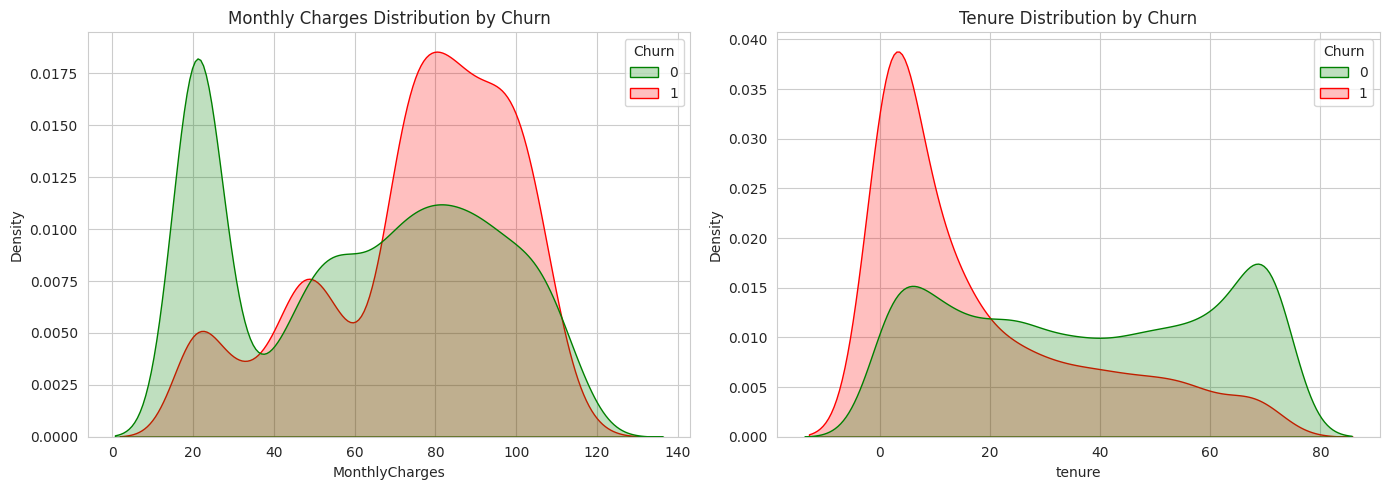

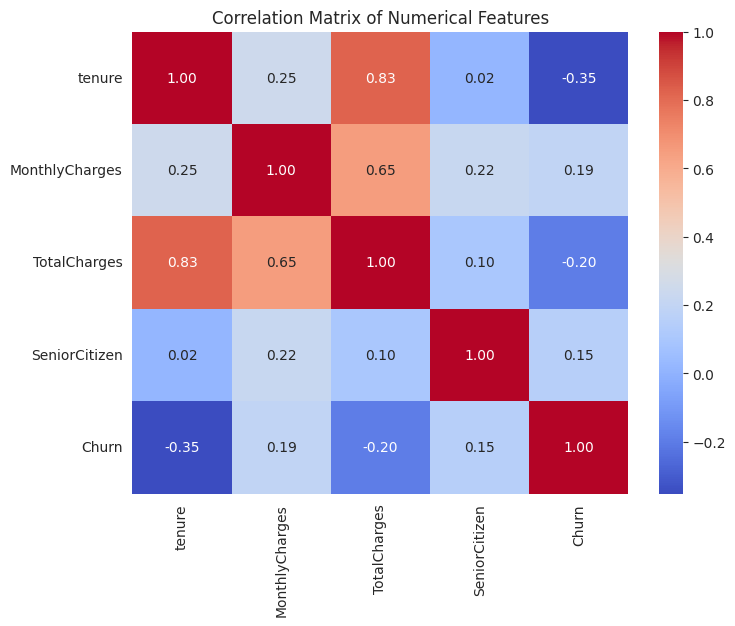

In [18]:
# CODE BLOCK E: NUMERICAL EDA (DISTRIBUTION BY CHURN)
import matplotlib.pyplot as plt
import seaborn as sns

# Re-combine training features and target for visualization
df_train = X_train.copy()
df_train['Churn'] = y_train

sns.set_style("whitegrid")

# Create figure for KDE plots (Distribution by Churn)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# 1. Monthly Charges vs Churn (Price Sensitivity)
sns.kdeplot(data=df_train, x='MonthlyCharges', hue='Churn', fill=True,
            common_norm=False, palette={1: 'red', 0: 'green'}, ax=ax[0])
ax[0].set_title('Monthly Charges Distribution by Churn')

# 2. Tenure vs Churn (New Customer Risk)
sns.kdeplot(data=df_train, x='tenure', hue='Churn', fill=True,
            common_norm=False, palette={1: 'red', 0: 'green'}, ax=ax[1])
ax[1].set_title('Tenure Distribution by Churn')

plt.tight_layout()
plt.show()

# Visualize Correlation Matrix (for all features)
# This requires running EDA on the full unencoded data for a cleaner matrix,
# but for simplicity, we use the original numeric columns:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Churn']
corr_matrix = df[numeric_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()